In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import xarray as xr

def plot_data_comparison(prior_filename, posterior_filename, num_realizations=100, y_limits=[200, 320]):
    reference_folder='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/REFERENCE'
    pickle_filename='Reference_metadata.pkl'
    nc_filename='ReferenceSimulation.nc'
    data_folder_path='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA'
    monitoring_positions = [[11, 11], [11, 21], [21, 11], [21, 21]]
    Nd_obs = 12
    
    with open(os.path.join(reference_folder, pickle_filename), 'rb') as f:
        metadata = pickle.load(f)

    reference_model = xr.open_dataset(os.path.join(reference_folder, nc_filename))
    time_range = reference_model.time.values

    obsData = [reference_model['Pressure'].isel(X=i).isel(Y=j).values[:Nd_obs] for (i, j) in monitoring_positions]
    dObs = np.array(obsData).flatten()
    
    load_data = lambda filename: np.array(pd.read_pickle(os.path.join(data_folder_path, filename)))

    DPrior = load_data(prior_filename)
    DPosterior = load_data(posterior_filename)
    CeDiag = np.where(np.array(0.05 * dObs[0:]) < 1e-3, 1e-3, 0.01 * dObs[:])
    
    
    Nd = DPrior.shape[0] // len(monitoring_positions) 
    reshaper = lambda data: data.reshape((4, Nd, -1))[:, :, :num_realizations]
    
     
    
    time_shift = Nd - Nd_obs
    tsf = len(time_range) - Nd

    fig, axes = plt.subplots(4, 2, figsize=(15, 20), sharey=True)
    for i, (ax_prior, ax_posterior) in enumerate(axes):
        #ax_prior.errorbar(time_range[:Nd_obs], dObs.reshape((4, Nd_obs))[i], yerr=CeDiag.reshape((4, Nd_obs))[i], fmt='o', color='r', label='Observed Data')
       # ax_posterior.errorbar(time_range[:Nd_obs], dObs.reshape((4, Nd_obs))[i], yerr=CeDiag.reshape((4, Nd_obs))[i], fmt='o', color='r', label='Observed Data')
        
        for realization in reshaper(DPrior)[i, :, :].T:
            ax_prior.plot(time_range[:Nd], realization, color='gray', alpha=0.8)
        for realization in reshaper(DPosterior)[i, :, :].T:
            ax_posterior.plot(time_range[:Nd], realization, color='blue', alpha=0.8)

        ax_prior.set_ylim(y_limits)
        ax_prior.set_title(f'Monitoring Point {i+1} - Prior', fontsize = 15)
        ax_posterior.set_title(f'Monitoring Point {i+1} - Posterior', fontsize = 15)
        ax_prior.set_xlabel('Time (days)', fontsize = 15)
        ax_posterior.set_xlabel('Time (days)' , fontsize = 15)
        ax_prior.set_ylabel('Pressure (bar)' , fontsize = 15)
        ax_prior.legend(loc='upper left')
        ax_posterior.legend(loc='upper left')

    plt.tight_layout()
    plt.show()
    
    
def plot_observation_points(path_model_nc):
    monitoring_positions = [[11, 11], [11, 21], [21, 11], [21, 21]]
    model = xr.open_dataset(path_model_nc)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(model['Perm'].values, cmap='viridis')
    for (i,j) in monitoring_positions:
        ax.plot(i, j, 'o', color='red', markersize=10)
        #remove the x and y ticks
        ax.set_xticks([])
        ax.set_yticks([])
    ax.set_title('Observation Points in the Permeability Field')
    plt.tight_layout()
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

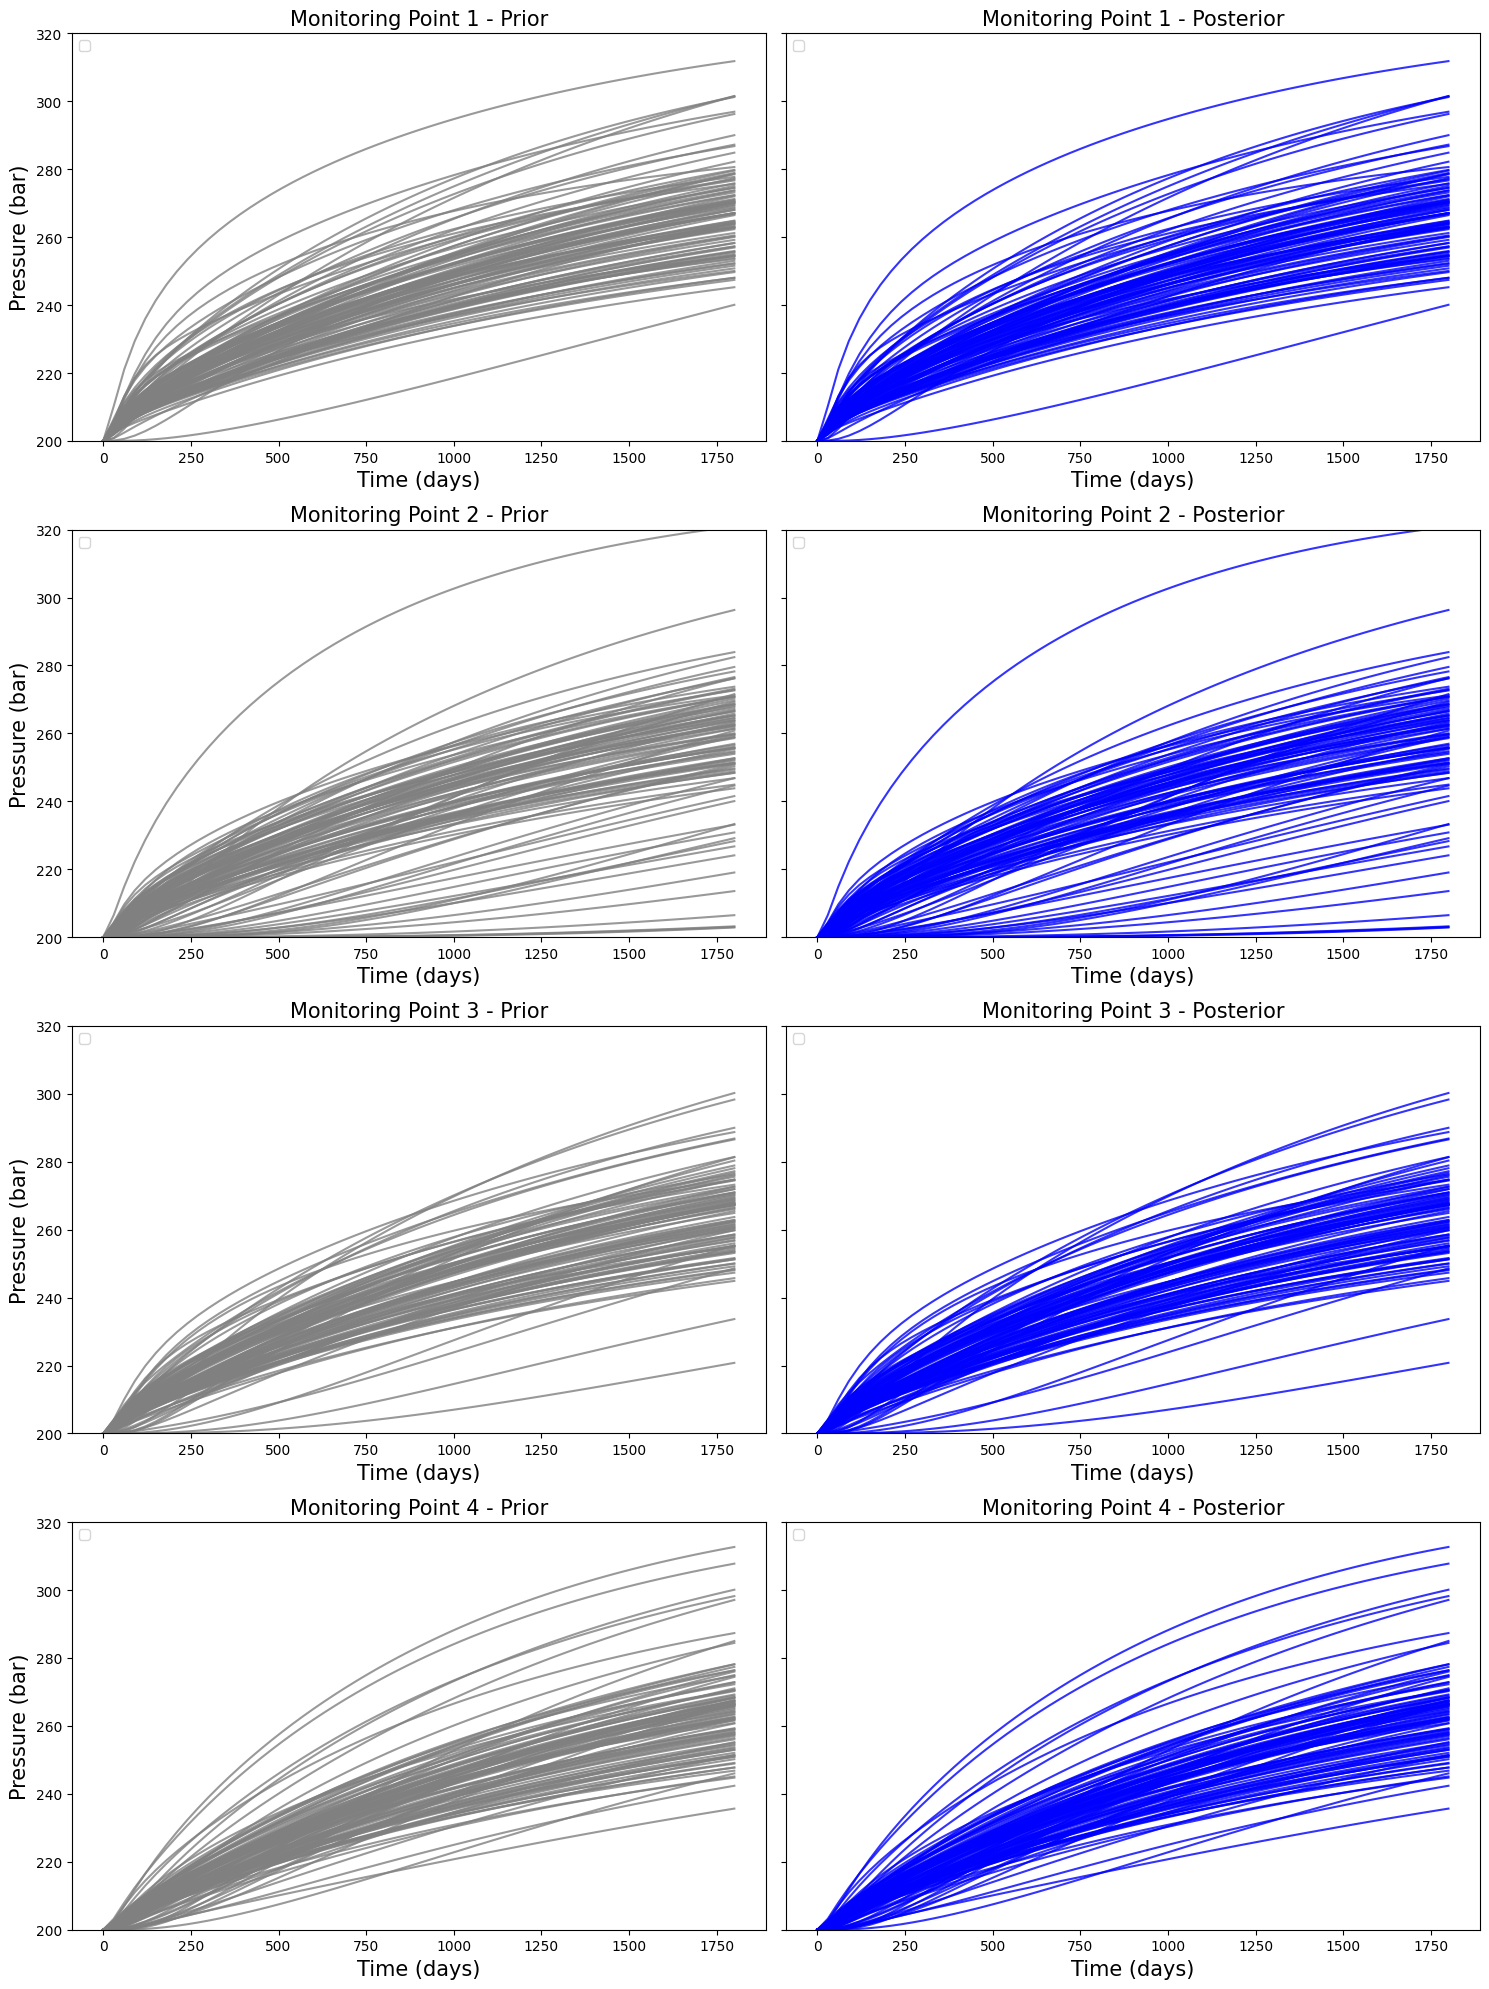

In [13]:
plot_data_comparison(prior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/simulations_Loc_None_PERM_Nit4_HF100_PX0/it0/D_0.pkl', posterior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/simulations_Loc_None_PERM_Nit4_HF100_PX0/it0/D_0.pkl')

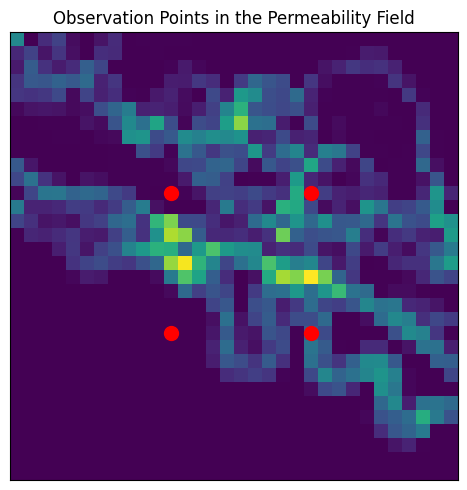

In [11]:
plot_observation_points('/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/simulations_Loc_None_PERM_Nit4_HF100_PX0/it0/geo/geo_1.nc')

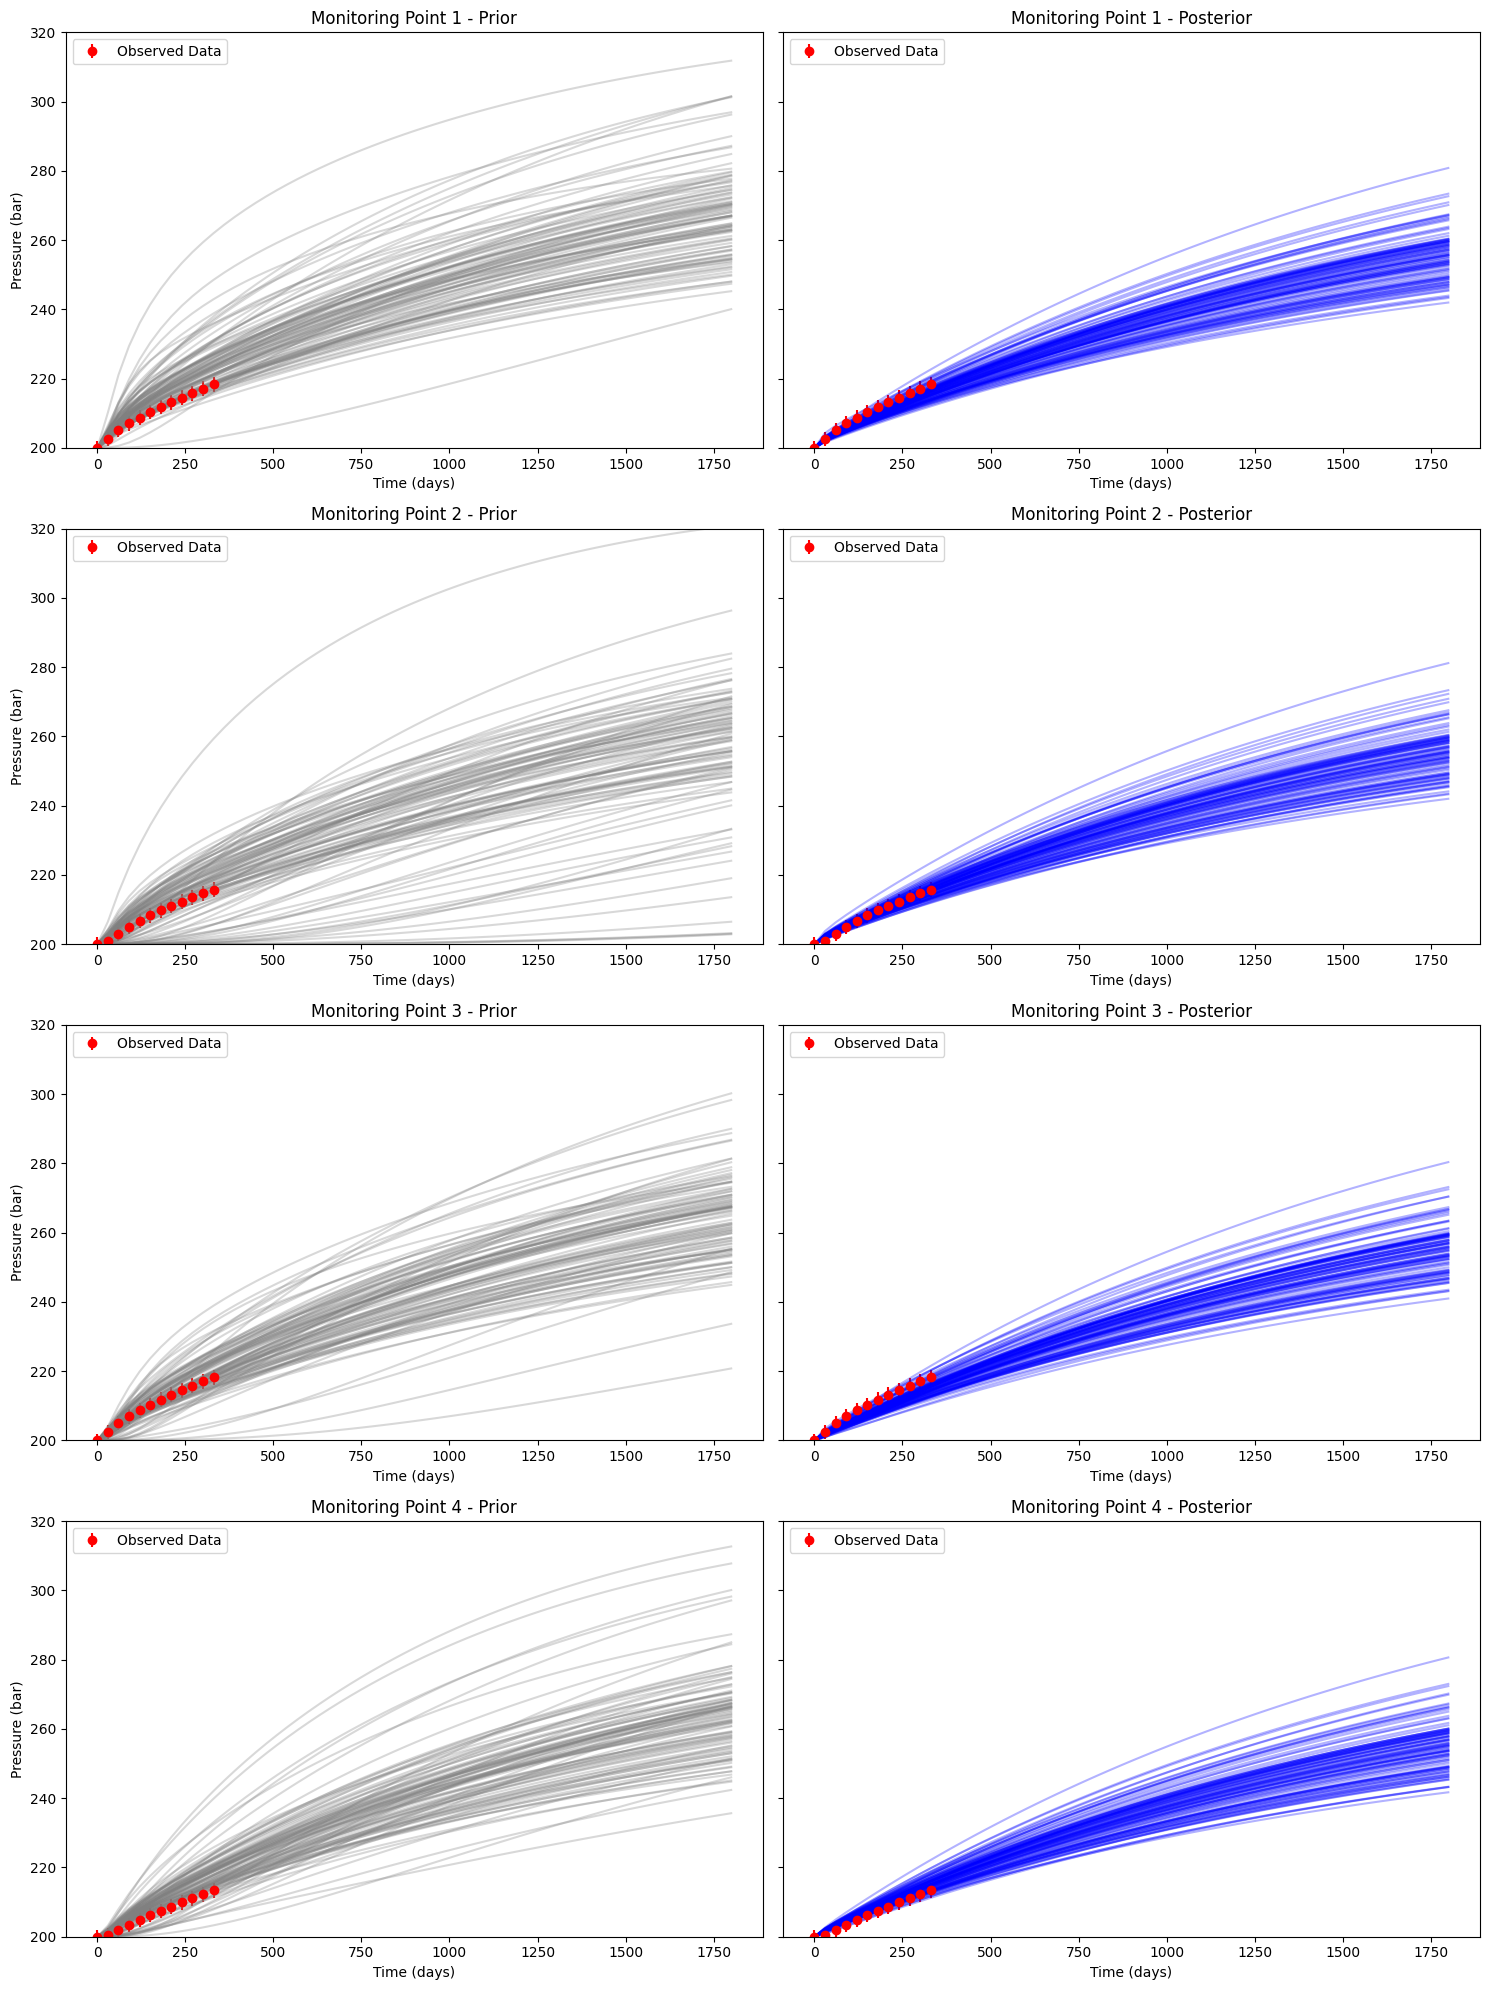

In [61]:
plot_data_comparison(prior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/VARIATIONAL/SINGLE_runs/DPrior_DARTS_consolidated.pkl', posterior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/VARIATIONAL/SINGLE_runs/DPost_DARTS_consolidated.pkl')

In [36]:
import pickle
import os
import pandas as pd

base_path = "/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/VARIATIONAL/SINGLE_runs/201steps_CASE_"
output_folder = "/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/VARIATIONAL/SINGLE_runs/"

def consolidate_files(file_name, output_name, num_cases):
    consolidated_data = []
    for case in range(num_cases):
        case_path = os.path.join(base_path + str(case), file_name)
        with open(case_path, 'rb') as f:
            data = pickle.load(f)
            # Transpose the DataFrame to make sure it's shape (1, 244)
            consolidated_data.append(np.array(data).T)

    # Concatenate DataFrames vertically to create a matrix of shape (num_cases, 244)
    consolidated_array = np.concatenate(consolidated_data, axis=0) # Fixed line

    # Ensure the final shape is (num_cases, 244)
    assert consolidated_array.shape == (num_cases, 244)

    # Saving the consolidated data
    output_path = os.path.join(output_folder, output_name)
    with open(output_path, 'wb') as f:
        pickle.dump(consolidated_array.T, f)
    print(f"{output_path} created successfully!")

num_cases = 100 # Adjust this to the total number of cases

consolidate_files('DPrior_DARTS.pkl', 'DPrior_DARTS_consolidated.pkl', num_cases)
consolidate_files('DPost_DARTS.pkl', 'DPost_DARTS_consolidated.pkl', num_cases)



/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/VARIATIONAL/SINGLE_runs/DPrior_DARTS_consolidated.pkl created successfully!
/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/VARIATIONAL/SINGLE_runs/DPost_DARTS_consolidated.pkl created successfully!


ValueError: 'x' and 'y' must have the same size

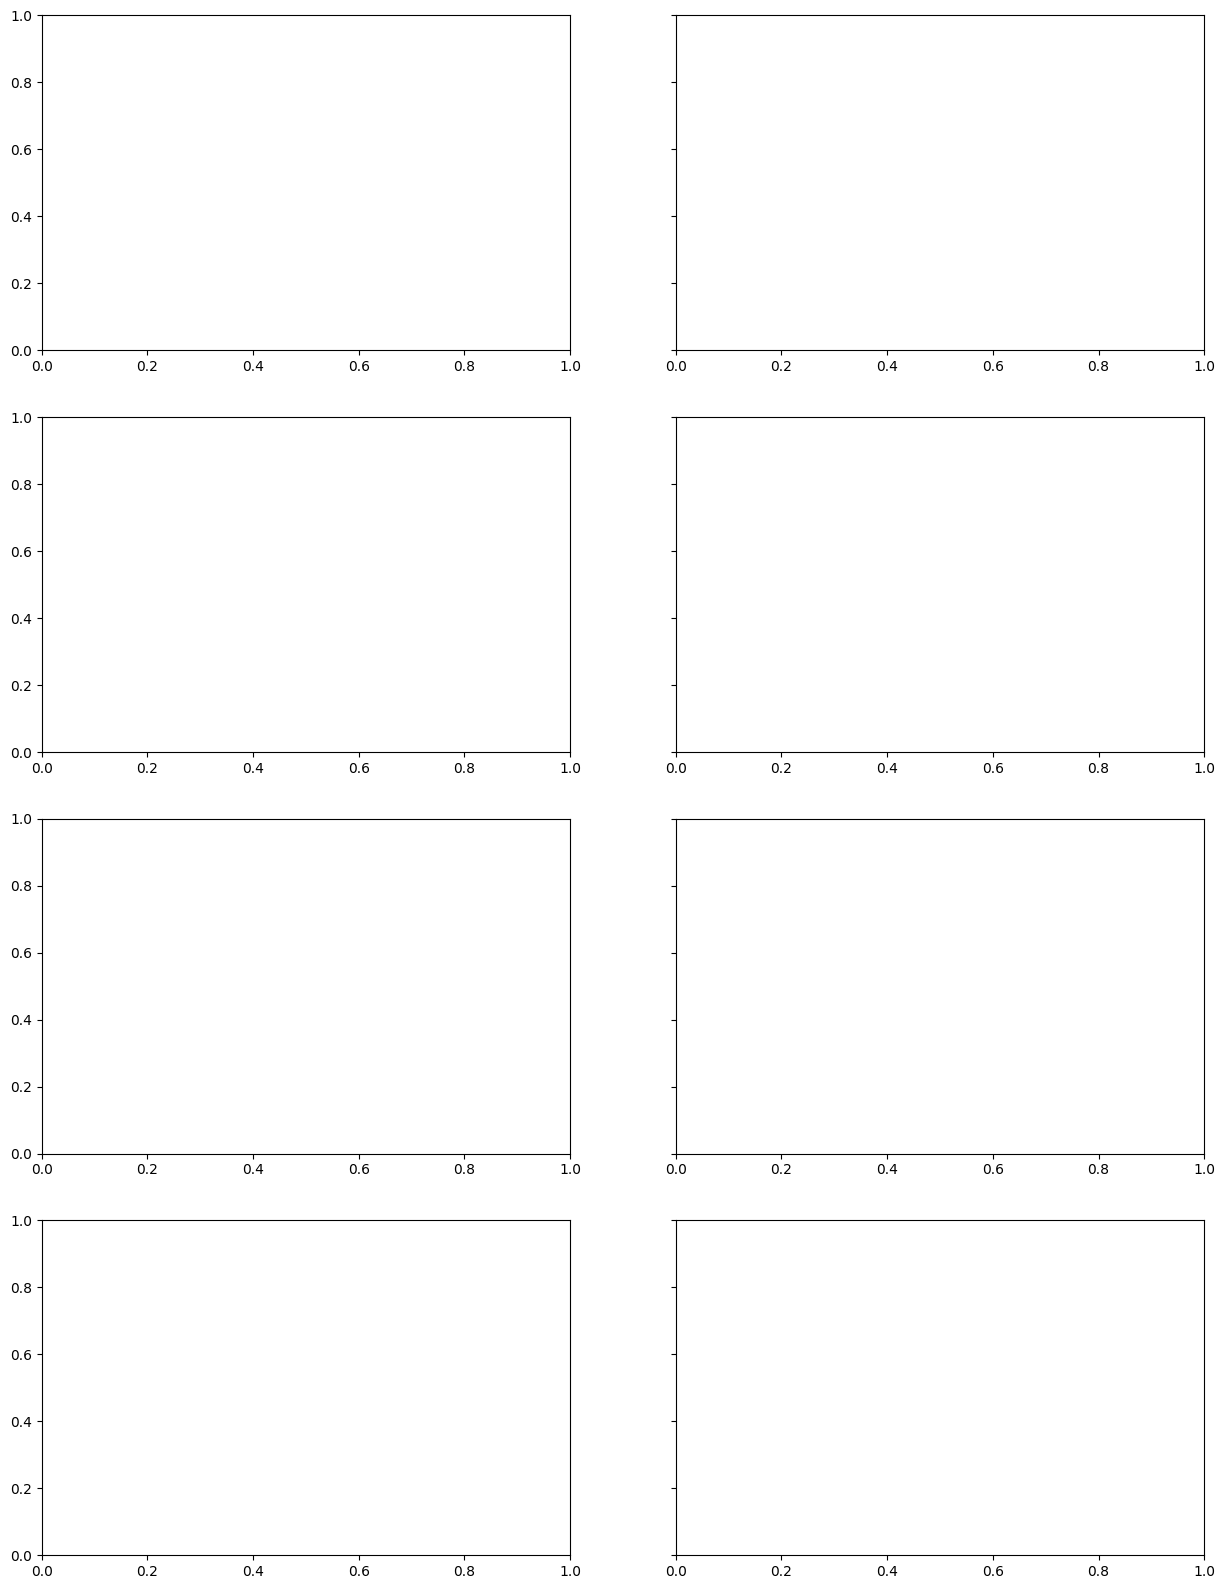

In [73]:
plot_data_comparison(prior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/datafilter12_REF1000_PARALLEL_simulations_Loc_None_PERM_Nit8_HF100_PX0/it0/D_0.pkl', posterior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/datafilter12_REF1000_PARALLEL_simulations_Loc_None_PERM_Nit8_HF100_PX0/it7/D_7.pkl')

In [14]:
plot_data_comparison(prior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/VARIATIONAL/SINGLE_runs/DPrior_DARTS_consolidated.pkl', posterior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/VARIATIONAL/SINGLE_runs/DPost_DARTS_consolidated.pkl')

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [15]:
load_data 

NameError: name 'load_data' is not defined

In [3]:
pd.read_pickle('/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/data12_REF1000_PARALLEL_simulations_Loc_None_PERM_Nit8_HF100_PX0/it7/D_7.pkl')

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
1,202.150406,203.029175,202.815689,203.074295,202.369202,202.202774,202.654526,201.956512,203.032669,201.997589,...,202.538620,202.662323,202.825012,201.784012,202.526016,202.329468,202.665039,202.460754,202.325714,202.840790
2,203.609406,204.849609,204.454285,205.221298,204.077713,203.678802,204.367279,203.212021,205.020981,203.253540,...,204.107147,204.234177,204.693268,203.045105,204.130798,203.858444,204.215683,203.902954,203.801849,204.571350
3,204.929794,206.365341,205.952103,207.242813,205.702347,204.984940,205.911026,204.355408,206.891495,204.382111,...,205.493164,205.572266,206.421005,204.180481,205.544373,205.241913,205.548599,205.155685,205.168320,206.097504
4,206.183548,207.792328,207.393326,209.231491,207.287613,206.219070,207.395630,205.445602,208.710434,205.467667,...,206.804794,206.834396,208.090927,205.272842,206.898224,206.574234,206.803085,206.337326,206.497284,207.550903
5,207.388016,209.175003,208.792526,211.191956,208.842087,207.409012,208.844177,206.494781,210.492142,206.524338,...,208.068985,208.054764,209.721848,206.336960,208.216629,207.874985,208.012451,207.479187,207.799545,208.960709
6,208.553513,210.525635,210.157547,213.122421,210.368484,208.567017,210.263535,207.510223,212.240463,207.557541,...,209.298126,209.244980,211.320755,207.377945,209.507385,209.150208,209.188583,208.592850,209.078644,210.337692
7,209.686340,211.848923,211.492584,215.021896,211.867920,209.698853,211.656601,208.497101,213.958313,208.570343,...,210.498398,210.409897,212.890625,208.398605,210.773254,210.402069,210.337372,209.683380,210.335342,211.686356
8,210.790894,213.147278,212.800888,216.889786,213.341721,210.807846,213.025101,209.459351,215.646637,209.564377,...,211.673309,211.552048,214.433502,209.400558,212.015808,211.631821,211.462082,210.752853,211.570267,213.009735
9,211.870499,214.422089,214.084900,218.726349,214.790680,211.895981,214.370132,210.399429,217.305847,210.540604,...,212.825439,212.673141,215.949936,210.384369,213.236221,212.840485,212.564804,211.802750,212.783951,214.309433


In [9]:

#comparer.process_data(prior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/PARALLEL_simulations_Loc_None_PERM_Nit4_HF500_PX0/it0/D_0.pkl', posterior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/PARALLEL_simulations_Loc_None_PERM_Nit4_HF500_PX0/it3/D_3.pkl', num_realizations=500)
#comparer.process_data(prior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/PARALLEL_simulations_Loc_None_PERM_Nit8_HF500_PX0/it0/D_0.pkl', posterior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/PARALLEL_simulations_Loc_None_PERM_Nit8_HF500_PX0/it7/D_7.pkl', num_realizations=500)
#comparer.process_data(prior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/PARALLEL_simulations_Loc_None_PERM_Nit16_HF500_PX0/it0/D_0.pkl', posterior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/PARALLEL_simulations_Loc_None_PERM_Nit16_HF500_PX0/it15/D_15.pkl', num_realizations=500)
#comparer.process_data(prior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/HYBRID_data_REF1000_PARALLEL_simulations_Loc_None_PERM_Nit4_HF100_PX0/it0/D_0.pkl', posterior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/HYBRID_data_REF1000_PARALLEL_simulations_Loc_None_PERM_Nit4_HF100_PX0/it3/D_3.pkl', num_realizations=100)
#comparer.process_data(prior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/HYBRID_data_REF1000_PARALLEL_simulations_Loc_None_PERM_Nit8_HF100_PX0/it0/D_0.pkl', posterior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/HYBRID_data_REF1000_PARALLEL_simulations_Loc_None_PERM_Nit8_HF100_PX0/it7/D_7.pkl', num_realizations=100)
comparer.process_data(prior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/data12_REF1000_PARALLEL_simulations_Loc_None_PERM_Nit8_HF100_PX0/it0/D_0.pkl', posterior_filename='/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/data12_REF1000_PARALLEL_simulations_Loc_None_PERM_Nit8_HF100_PX0/it7/D_7.pkl', num_realizations=100)

ValueError: cannot reshape array of size 240 into shape (4,48)

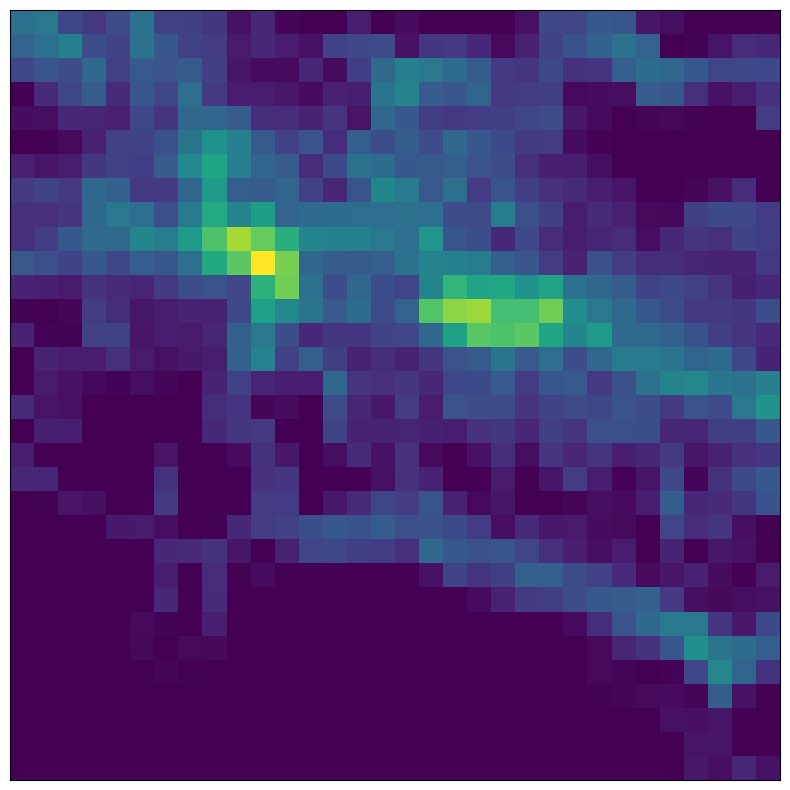

In [69]:
import xarray as xr
import matplotlib.pyplot as plt

# Function to plot the permeability field without ticks
def plot_permeability_field(nc_filename):
    # Open the NetCDF file
    data = xr.open_dataset(nc_filename)
    
    # Extract the permeability field
    permeability = data['Perm'].values

    # Plot the permeability field
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.imshow(permeability, cmap='viridis')

    # Remove the x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Add a colorbar
    #cbar = fig.colorbar(cax)
    #cbar.set_label('Permeability')

    #plt.title('Permeability Field')
    plt.tight_layout()
    plt.show()

# Usage example
nc_filename = '/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/prior_geomodels/prior_0.nc' # Replace with your path
plot_permeability_field(nc_filename)


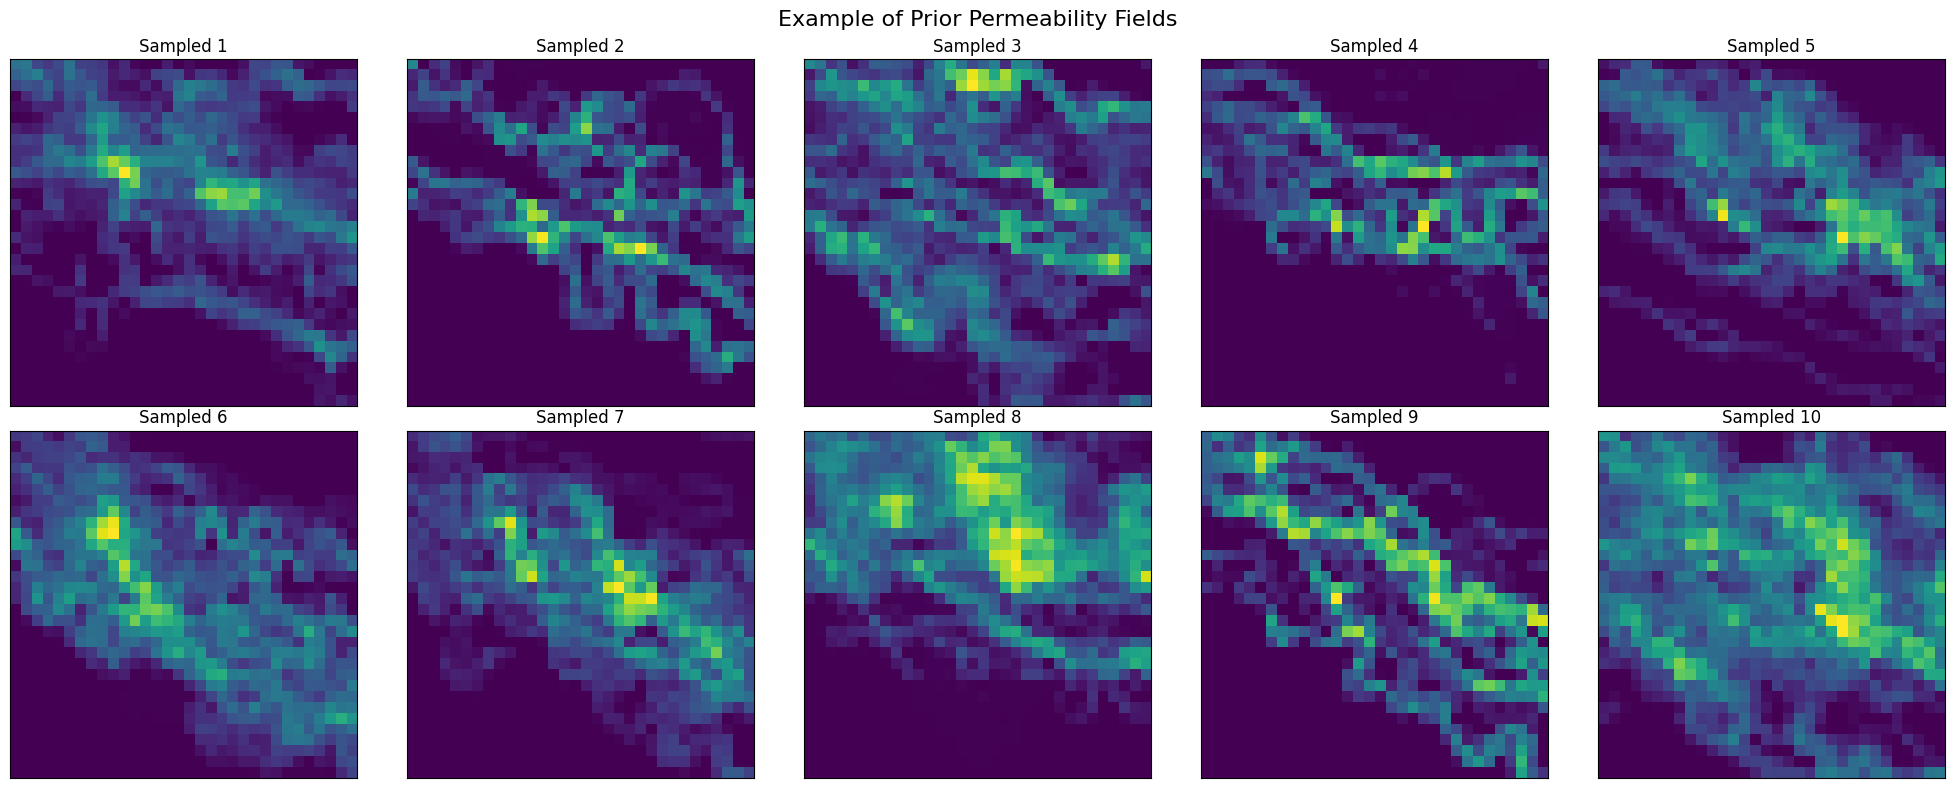

In [74]:
import xarray as xr
import matplotlib.pyplot as plt

def plot_permeability_fields(base_path, file_prefix, start_index, num_files=10):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    for i in range(num_files):
        # Construct the file path
        file_path = f"{base_path}/{file_prefix}_{i+start_index}.nc"
        
        # Open the NetCDF file
        data = xr.open_dataset(file_path)

        # Extract the permeability field
        permeability = data['Perm'].values

        # Determine subplot index
        row = i // 5
        col = i % 5
        ax = axes[row, col]

        # Plot the permeability field
        cax = ax.imshow(permeability, cmap='viridis')

        # Remove the x and y ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Add a title to each subplot
        ax.set_title(f'Sampled {i+1}', fontsize=12)

    # Add a colorbar
    #fig.colorbar(cax, ax=axes.ravel().tolist(), orientation='horizontal')
    #intluce a title to the figure
    fig.suptitle('Example of Prior Permeability Fields', fontsize=16)
    plt.tight_layout()
    plt.show()

# Usage
base_path = "/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/prior_geomodels"
file_prefix = "prior"
start_index = 0
plot_permeability_fields(base_path, file_prefix, start_index)


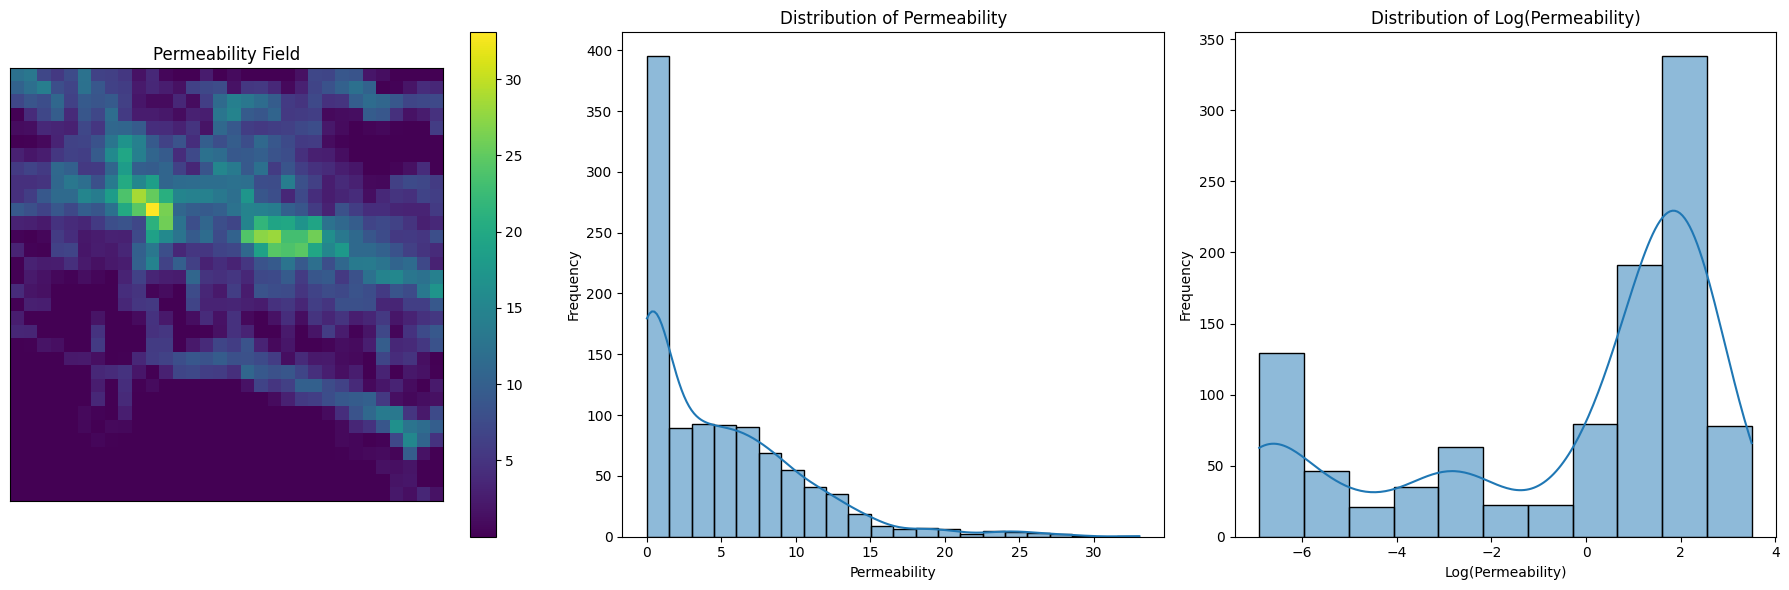

In [75]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_perm_stats(file_path):
    # Open the NetCDF file
    data = xr.open_dataset(file_path)

    # Extract the permeability field
    permeability = data['Perm'].values

    # Compute the logarithm of the permeability
    log_perm = np.log(permeability)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the permeability field
    cax = axes[0].imshow(permeability, cmap='viridis')
    fig.colorbar(cax, ax=axes[0], orientation='vertical')
    axes[0].set_title('Permeability Field')
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Plot the distribution of the permeability
    sns.histplot(permeability.flatten(), kde=True, ax=axes[1])
    axes[1].set_title('Distribution of Permeability')
    axes[1].set_xlabel('Permeability')
    axes[1].set_ylabel('Frequency')

    # Plot the distribution of the logarithm of the permeability
    sns.histplot(log_perm.flatten(), kde=True, ax=axes[2])
    axes[2].set_title('Distribution of Log(Permeability)')
    axes[2].set_xlabel('Log(Permeability)')
    axes[2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Usage
file_path = "/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/prior_geomodels/prior_0.nc"
plot_perm_stats(file_path)


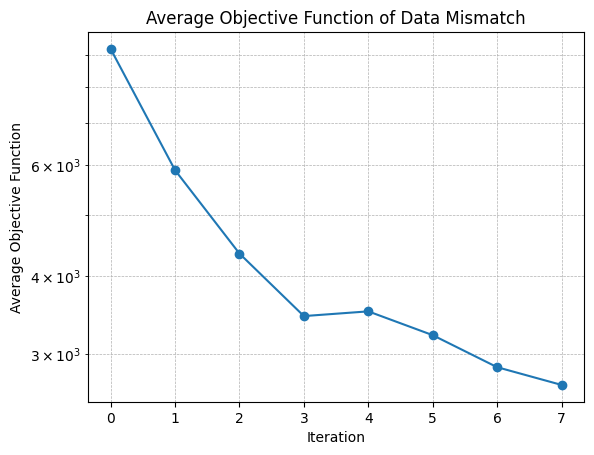

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_avg_objective_function(base_path, num_iterations):
    avg_values = []
    for i in range(num_iterations):
        file_path = f"{base_path}/it{i}/MObj_{i}.pkl"
        data = pd.read_pickle(file_path)
        
        # Assuming the objective function values are stored in the DataFrame directly
        avg_value = data.mean()
        
        avg_values.append(avg_value)

    # Create a semilog plot of the average values
    plt.semilogy(avg_values, marker='o')
    plt.title('Average Objective Function of Data Mismatch')
    plt.xlabel('Iteration')
    plt.ylabel('Average Objective Function')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.xticks(ticks=range(num_iterations))
    plt.show()

# Usage
base_path = "/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/simulations_Loc_None_PERM_Nit8_HF100_PX0"
num_iterations = 8 # Update based on the number of iterations you have
plot_avg_objective_function(base_path, num_iterations)


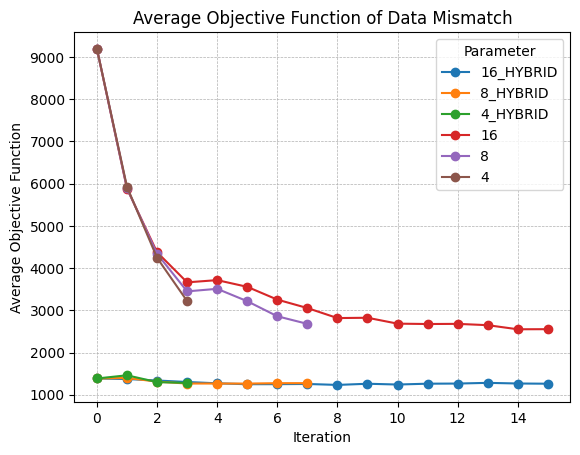

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

def get_avg_value(file_path):
    # Read the data
    data = pd.read_pickle(file_path)
    
    # Compute and return the average value
    return data.mean()

def plot_avg_values(paths_and_files):
    avg_values = []
    labels = []
    
    # Iterate over the given paths and files
    for label, file_paths in paths_and_files.items():
        avg_for_label = [get_avg_value(file_path) for file_path in file_paths]
        avg_values.append(avg_for_label)
        labels.append(label)

    # Create a plot for the average values
    for avg_val, label in zip(avg_values, labels):
        plt.plot(avg_val, marker='o', label=label)
    
    #plt.semilogy(avg_values, marker='o')
    plt.title('Average Objective Function of Data Mismatch')
    plt.xlabel('Iteration')
    plt.ylabel('Average Objective Function')
    plt.legend(title='Parameter')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.show()

# Usage
paths_and_files = {
    '16_HYBRID': [f"/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/HYBRID_data_REF1000_PARALLEL_simulations_Loc_None_PERM_Nit16_HF100_PX0/it{i}/MObj_{i}.pkl" for i in range(16)],
    '8_HYBRID': [f"/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/HYBRID_data_REF1000_PARALLEL_simulations_Loc_None_PERM_Nit8_HF100_PX0/it{i}/MObj_{i}.pkl" for i in range(8)],
    '4_HYBRID': [f"/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/HYBRID_data_REF1000_PARALLEL_simulations_Loc_None_PERM_Nit4_HF100_PX0/it{i}/MObj_{i}.pkl" for i in range(4)],
    '16': [f"/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/simulations_Loc_None_PERM_Nit16_HF100_PX0/it{i}/MObj_{i}.pkl" for i in range(16)],
    '8': [f"/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/simulations_Loc_None_PERM_Nit8_HF100_PX0/it{i}/MObj_{i}.pkl" for i in range(8)],
    '4': [f"/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/simulations_Loc_None_PERM_Nit4_HF100_PX0/it{i}/MObj_{i}.pkl" for i in range(4)],
}


plot_avg_values(paths_and_files)


In [107]:
def plot_avg_values(paths_and_files):
    avg_values = []
    labels = []
    
    # Iterate over the given paths and files
    for label, file_paths in paths_and_files.items():
        avg_for_label = [get_avg_value(file_path) for file_path in file_paths]
        avg_values.append(avg_for_label)
        labels.append(label)

    # Create a plot for the average values
    for avg_val, label in zip(avg_values, labels):
        plt.semilogy(avg_val, marker='o', label=label)  # Here's the change

    plt.title('Average Objective Function of Data Mismatch')
    plt.xlabel('Iteration')
    plt.ylabel('Average Objective Function')
    plt.legend(title='Parameter')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.show()


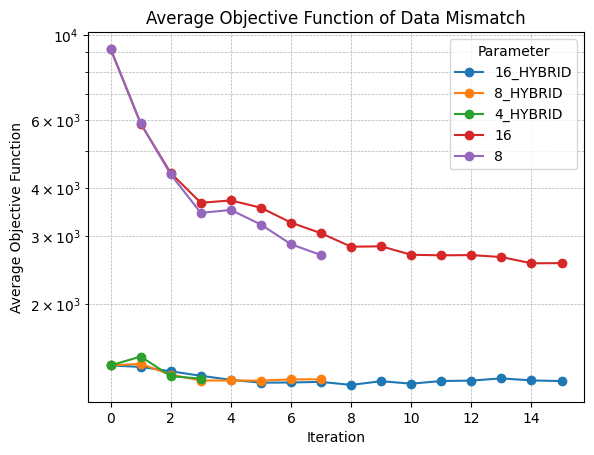

In [108]:
plot_avg_values(paths_and_files)

In [120]:
Mprior = np.exp(np.array(pd.read_pickle('/samoa/data/smrserraoseabr/NO-DA/historymatching/ESMDA/simulations_Loc_Correlation_PERM_Nit8_HF100_PX0/it0/MGrid_0.pkl')))

In [121]:
Mprior = Mprior.reshape(32,32,100)

In [122]:
Mmean, Mstd = np.mean(Mprior, axis=-1), np.std(Mprior, axis=-1)

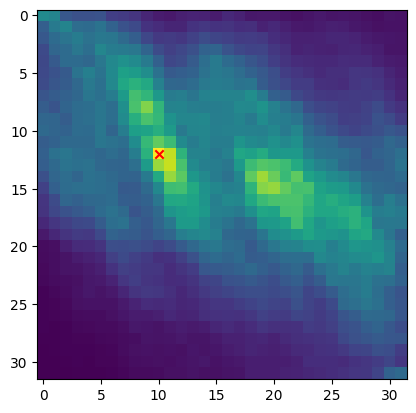

In [136]:
plt.imshow(Mmean)
plt.scatter(j,i,marker='x',color='r')


In [131]:
Mmeanmax = np.max(Mmean)
#which i and j are the max
i,j=np.where(Mmean==Mmeanmax)

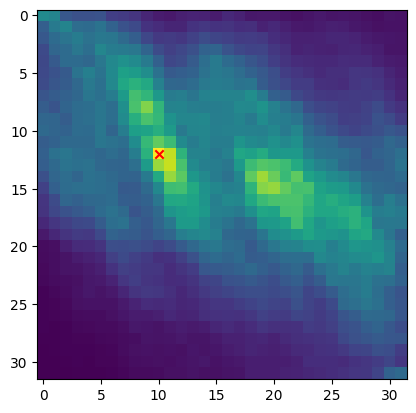

In [137]:
plt.imshow(Mmean)
plt.scatter(j,i,marker='x',color='r')
#anottate 

Text([20], [22], 'i=[12]')

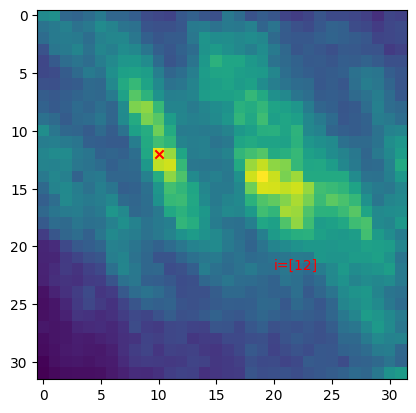

In [139]:
plt.imshow(Mstd)
plt.scatter(j,i,marker='x',color='r')
#ANNOTATE THE I AND J VALUES IN THE IMAGE
plt.annotate('i='+str(i),xy=(j,i),xytext=(j+10,i+10),color='r')

In [ ]:
#Rank the Mmean of the 5 most popular movies in the dataset excluding movies with less than 100 ratings

Top10 = 

In [143]:
#rank the Mmean matix and get the index
Mmean_rank = np.argsort(Mmean, axis=1)


In [145]:
Mmean_rank.shape

(32, 32)

In [148]:
np.array([0,1,2,3,4,5,6,7,8,9])[:3]

array([0, 1, 2])